  DrugID     Month  MarketingSpend  CompetitorPrice  AveragePrice  Season  \
0   D005  November        49240.41            39.90         42.20  Spring   
1   D002  December       226691.45            13.16         96.12  Spring   
2   D001   October       371644.16            38.05        100.84  Summer   
3   D001       May       182960.93            29.92         27.72  Summer   
4   D005   January       106119.24            41.75         61.89    Fall   

   EconomicIndex  DemographicFactor  PrescriptionRate  SalesVolume  
0           0.97               0.73            153.10      2737.76  
1           1.06               1.16            335.42     18633.40  
2           1.13               0.77            392.25     20094.96  
3           0.80               0.67            344.99     17241.41  
4           1.01               1.10            225.03     19692.12  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column     

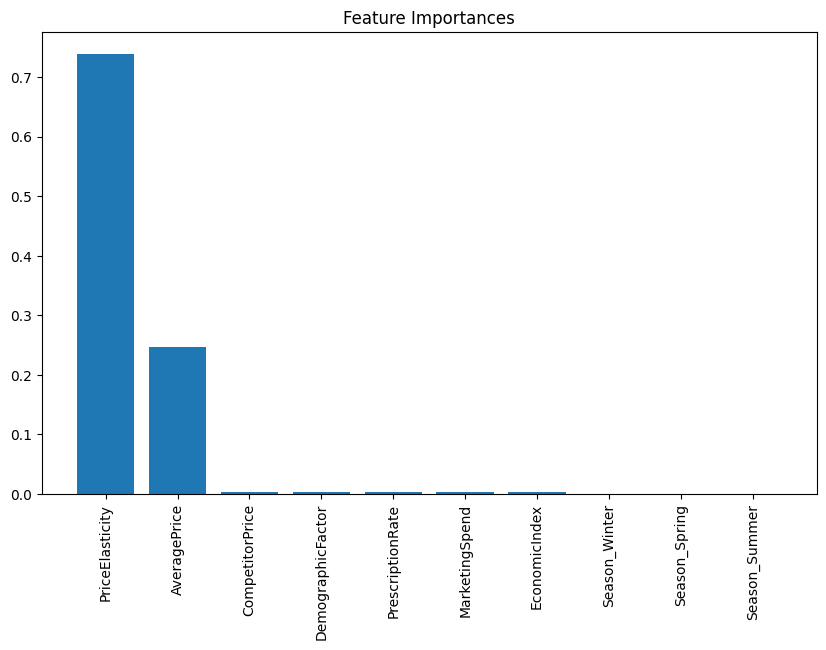

Top features influencing drug sales:
PriceElasticity      0.738686
AveragePrice         0.246515
CompetitorPrice      0.003667
DemographicFactor    0.002837
PrescriptionRate     0.002576
dtype: float64


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Data Exploration and Preprocessing
# Load the dataset
file_path = r"C:\Users\Vishnu Priya\Downloads\drug_sales_prediction_dataset.csv"
df = pd.read_csv(file_path)

# Initial Exploration
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Handle missing values (filling with median for numeric columns)
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Convert categorical variables into numerical ones using One-Hot Encoding
df = pd.get_dummies(df, columns=['Season'], drop_first=True)

# 2. Feature Engineering
# Feature Scaling
scaler = StandardScaler()
df[['MarketingSpend', 'CompetitorPrice', 'AveragePrice', 'EconomicIndex', 'DemographicFactor', 'PrescriptionRate']] = scaler.fit_transform(
    df[['MarketingSpend', 'CompetitorPrice', 'AveragePrice', 'EconomicIndex', 'DemographicFactor', 'PrescriptionRate']])

# New feature: Price Elasticity (SalesVolume change relative to AveragePrice)
df['PriceElasticity'] = df['SalesVolume'] / df['AveragePrice']

# Splitting dataset into features and target variable
X = df.drop(columns=['SalesVolume', 'DrugID', 'Month'])  # Drop non-informative columns
y = df['SalesVolume']

# 3. Model Building
# Split dataset into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model pipelines
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train models
model_performance = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    model_performance[name] = {
        
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

# Display model performances
model_perf_df = pd.DataFrame(model_performance).T
print(model_perf_df)

# 4. Hyperparameter tuning with GridSearchCV (for Random Forest as an example)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Evaluate the best Random Forest model
y_pred_best_rf = best_rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_rf = r2_score(y_test, y_pred_best_rf)


print(f"Best Random Forest - MAE: {mae_rf}, MSE: {mse_rf}, R2: {r2_rf}")

# 5. Feature Importance (using Random Forest as an example)
importances = best_rf_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_idx)), importances[sorted_idx], align="center")
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.show()

# 6. Insights and Recommendations
important_features = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top features influencing drug sales:")
print(important_features.head())




